# Prepare and Deploy a TensorFlow Model to AI Platform for Online Serving

This Notebook demonstrates how to prepare a TensorFlow 2.x model and deploy it for serving with AI Platform Prediction. This example uses the pretrained [ResNet V2 101](https://tfhub.dev/google/imagenet/resnet_v2_101/classification/4) image classification model from [TensorFlow Hub](https://tfhub.dev/) (TF Hub).

The Notebook covers the following steps:
1. Downloading and running the ResNet module from TF Hub
2. Creating serving signatures for the module
3. Exporting the model as a SavedModel
4. Deploying the SavedModel to AI Platform Prediction
5. Validating the deployed model


## Setup

This Notebook was tested on **AI Platform Notebooks** using the standard TF 2.8 image.

### Import libraries

In [1]:
import base64
import os
import json
import requests
import time
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

from typing import List, Optional, Text, Tuple

2023-09-05 20:08:54.959880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 20:09:01.344139: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-09-05 20:09:01.345405: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

### Configure GCP environment settings

In [50]:
PROJECT_ID = 'ultra-guard-361718' # Set your project Id
BUCKET = 'ml_project_bucket_1' # Set your bucket name Id
REGION = 'us-east4'  # Set your region for deploying the model
MODEL_NAME = 'resnet_classifier'
MODEL_VERSION = 'v1'
GCS_MODEL_LOCATION = 'gs://{}/models/{}/{}'.format(BUCKET, MODEL_NAME, MODEL_VERSION)
THUB_MODEL_HANDLE = 'https://tfhub.dev/google/imagenet/resnet_v2_101/classification/4'
IMAGENET_LABELS_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
IMAGES_FOLDER = 'test_images'

### Create a local workspace

In [36]:
LOCAL_WORKSPACE = '/tmp/workspace'
if tf.io.gfile.exists(LOCAL_WORKSPACE):
    print("Removing previous workspace artifacts...")
    tf.io.gfile.rmtree(LOCAL_WORKSPACE)

print("Creating a new workspace...")
tf.io.gfile.makedirs(LOCAL_WORKSPACE)

Removing previous workspace artifacts...
Creating a new workspace...


## 1. Loading and Running the ResNet Module

### 1.1. Download and instantiate the model

In [37]:
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = 'True'

local_savedmodel_path = hub.resolve(THUB_MODEL_HANDLE)

print(local_savedmodel_path)
!ls -la {local_savedmodel_path}

/var/tmp/tfhub_modules/7b8093cf6e9836037eb01298256d50901c6e2cbb
total 2956
drwxr-xr-x 4 jupyter jupyter    4096 Sep  5 20:12 .
drwxr-xr-x 3 jupyter jupyter    4096 Sep  5 20:12 ..
drwxr-xr-x 2 jupyter jupyter    4096 Sep  5 20:12 assets
-rw-r--r-- 1 jupyter jupyter 3007213 Sep  5 20:12 saved_model.pb
drwxr-xr-x 2 jupyter jupyter    4096 Sep  5 20:12 variables


In [38]:
model = hub.load(THUB_MODEL_HANDLE)

The expected input to most TF Hub TF2 image classification models, including ResNet 101, is a rank 4 tensor conforming to the following tensor specification: `tf.TensorSpec([None, height, width, 3], tf.float32)`. For the ResNet 101 model, the expected image size is `height x width = 224 x 224`. The color values for all channels are expected to be normalized to the [0, 1] range. 

The output of the model is a batch of logits vectors. The indices into the logits are the `num_classes = 1001` classes  from the ImageNet dataset. The mapping from indices to class labels can be found in the [labels file](download.tensorflow.org/data/ImageNetLabels.txt) with class 0 for "background", followed by 1000 actual ImageNet classes.
    



We will now test the model on a couple of JPEG images. 

### 1.2. Display sample images

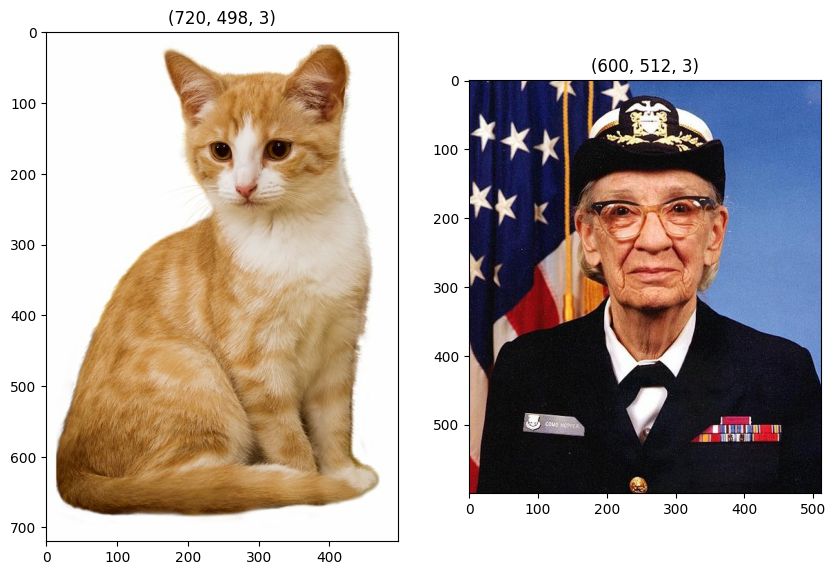

In [6]:
image_list = [tf.io.read_file(os.path.join(IMAGES_FOLDER, image_path))
         for image_path in os.listdir(IMAGES_FOLDER)]

ncolumns = len(image_list) if len(image_list) < 4 else 4
nrows = int(len(image_list) // ncolumns)
fig, axes = plt.subplots(nrows=nrows, ncols=ncolumns, figsize=(10,10))
for axis, image in zip(axes.flat[0:], image_list):
    decoded_image = tf.image.decode_image(image)
    axis.set_title(decoded_image.shape)
    axis.imshow(decoded_image.numpy())

### 1.3. Preprocess the testing images

The images need to be preprocessed to conform to the format expected by the ResNet101 model.

In [7]:
def _decode_and_scale(image, size):
    image = tf.image.decode_image(image, expand_animations=False)
        
    image_height = image.shape[0]
    image_width = image.shape[1]
    crop_size = tf.minimum(image_height, image_width)
    offset_height = ((image_height - crop_size) + 1) // 2
    offset_width = ((image_width - crop_size) + 1) // 2
        
    image = tf.image.crop_to_bounding_box(image, offset_height, offset_width, crop_size, crop_size)
    image = tf.cast(tf.image.resize(image, [size, size]), tf.uint8)
    
    return image

In [8]:
size = 224

raw_images = tf.stack(image_list)
preprocessed_images = tf.map_fn(lambda x: _decode_and_scale(x, size), raw_images, dtype=tf.uint8)
preprocessed_images = tf.image.convert_image_dtype(preprocessed_images, tf.float32)
print(preprocessed_images.shape)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(2, 224, 224, 3)


### 2.4. Run inference

In [9]:
predictions = model(preprocessed_images)
predictions

<tf.Tensor: shape=(2, 1001), dtype=float32, numpy=
array([[ 0.27374715, -1.2126323 , -0.8585876 , ..., -1.8846455 ,
         0.2523735 ,  1.8259864 ],
       [ 0.28163522,  0.6145909 , -0.00311571, ..., -0.5948273 ,
        -0.05215321, -0.11519504]], dtype=float32)>

The model returns a batch of arrays with logits. This is not a very user friendly output so we will convert it to the list of ImageNet class labels.

In [10]:
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    IMAGENET_LABELS_URL)
imagenet_labels = np.array(open(labels_path).read().splitlines())

10484/10484 [==============================] - 0s 0us/step




We will display the 5 highest ranked labels for each image

In [11]:
for prediction in list(predictions):
    decoded = imagenet_labels[np.argsort(prediction.numpy())[::-1][:5]]
    print(list(decoded))

['Egyptian cat', 'tiger cat', 'tabby', 'lynx', 'Siamese cat']
['military uniform', 'suit', 'Windsor tie', 'pickelhaube', 'bow tie']


## 2. Create Serving Signatures

The inputs and outputs of the model as used during model training may not be optimal for serving. For example, in a typical training pipeline, feature engineering is performed as a separate step preceding model training and hyperparameter tuning. When serving the model, it may be more optimal to embed the feature engineering logic into the serving interface rather than require a client application to preprocess data.


The ResNet V2 101 model from TF Hub is optimized for recomposition and fine tuning. Since there are no serving signatures in the model's metadata, it cannot be served with TF Serving as is.

In [12]:
list(model.signatures)

[]

To make it servable, we need to add a serving signature(s) describing the inference method(s) of the model. 

We will add two signatures: 
1. **The default signature** - This will expose the default predict method of the ResNet101 model.
2. **Prep/post-processing signature** - Since the expected inputs to this interface require a relatively complex image preprocessing to be performed by a client, we will also expose an alternative signature that embeds the preprocessing and postprocessing logic and accepts raw unprocessed images and returns the list of ranked class labels and associated label probabilities. 

The signatures are created by defining a custom module class derived from the `tf.Module` base class that encapsulates our ResNet model and extends it with a method implementing the image preprocessing and output postprocessing logic. The default method of the custom module is mapped to the default method of the base ResNet module to maintain the analogous interface. 

The custom module will be exported as `SavedModel` that includes the original model, the preprocessing logic, and two serving signatures.

This technique can be generalized to other scenarios where you need to extend a TensorFlow model and you have access to the serialized `SavedModel` but you don't have access to the Python code implementing the model.


#### 2.1. Define the custom serving module

In [39]:
LABELS_KEY = 'labels'
PROBABILITIES_KEY = 'probabilities'
NUM_LABELS = 5

class ServingModule(tf.Module):
    """
    A custom tf.Module that adds image preprocessing and output post processing to
    a base TF 2 image classification model from TF Hub. 
    """

    def __init__(self, base_model, input_size, output_labels):
        super(ServingModule, self).__init__()
        self._model = base_model
        self._input_size = input_size
        self._output_labels = tf.constant(output_labels, dtype=tf.string)
        

    def _decode_and_scale(self, raw_image):
        """
        Decodes, crops, and resizes a single raw image.
        """
        
        image = tf.image.decode_image(raw_image, dtype=tf.dtypes.uint8, expand_animations=False)
        image_shape = tf.shape(image)
        image_height = image_shape[0]
        image_width = image_shape[1]
        crop_size = tf.minimum(image_height, image_width)
        offset_height = ((image_height - crop_size) + 1) // 2
        offset_width = ((image_width - crop_size) + 1) // 2
        
        image = tf.image.crop_to_bounding_box(image, offset_height, offset_width, crop_size, crop_size)
        image = tf.image.resize(image, [self._input_size, self._input_size])
        image = tf.cast(image, tf.uint8)
    
        return image
    
    def _preprocess(self, raw_inputs):
        """
        Preprocesses raw inputs as sent by the client.
        """
        
        # A mitigation for https://github.com/tensorflow/tensorflow/issues/28007
        with tf.device('/cpu:0'):
            images = tf.map_fn(self._decode_and_scale, raw_inputs, dtype=tf.uint8)
        images = tf.image.convert_image_dtype(images, tf.float32)
        
        return images
        
    def _postprocess(self, model_outputs):
        """
        Postprocesses outputs returned by the base model.
        """
        
        probabilities = tf.nn.softmax(model_outputs)
        indices = tf.argsort(probabilities, axis=1, direction='DESCENDING')
        
        return {
            LABELS_KEY: tf.gather(self._output_labels, indices, axis=-1)[:,:NUM_LABELS],
            PROBABILITIES_KEY: tf.sort(probabilities, direction='DESCENDING')[:,:NUM_LABELS]
        }
        

    @tf.function(input_signature=[tf.TensorSpec([None, 224, 224, 3], tf.float32)])
    def __call__(self, x):
        """
        A pass-through to the base model.
        """
        
        return self._model(x)

    @tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
    def predict_labels(self, raw_images):
        """
        Preprocesses inputs, calls the base model 
        and postprocesses outputs from the base model.
        """
        
        # Call the preprocessing handler
        images = self._preprocess(raw_images)
        
        # Call the base model
        logits = self._model(images)
        
        # Call the postprocessing handler
        outputs = self._postprocess(logits)
        
        return outputs
        
    
serving_module = ServingModule(model, 224, imagenet_labels)

#### 2.2. Test the custom serving module

In [40]:
predictions = serving_module.predict_labels(raw_images)
predictions

{'labels': <tf.Tensor: shape=(2, 5), dtype=string, numpy=
 array([[b'Egyptian cat', b'tiger cat', b'tabby', b'lynx', b'Siamese cat'],
        [b'military uniform', b'suit', b'Windsor tie', b'pickelhaube',
         b'bow tie']], dtype=object)>,
 'probabilities': <tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[8.2705313e-01, 1.3128255e-01, 4.1054998e-02, 5.7081244e-04,
         1.8924709e-05],
        [9.4001341e-01, 4.8532832e-02, 6.4066425e-03, 2.0130021e-03,
         6.0433906e-04]], dtype=float32)>}

## 3. Save the custom serving module as `SavedModel`

In [41]:
model_path = os.path.join(LOCAL_WORKSPACE, MODEL_NAME, MODEL_VERSION)

default_signature = serving_module.__call__.get_concrete_function()
preprocess_signature = serving_module.predict_labels.get_concrete_function()
signatures = {
    'serving_default': default_signature,
    'serving_preprocess': preprocess_signature
}

tf.saved_model.save(serving_module, model_path, signatures=signatures)

INFO:tensorflow:Assets written to: /tmp/workspace/resnet_classifier/v1/assets


INFO:tensorflow:Assets written to: /tmp/workspace/resnet_classifier/v1/assets


### 3.1. Inspect the `SavedModel`

In [42]:
!saved_model_cli show --dir {model_path} --tag_set serve --all

2023-09-05 20:29:21.364801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 20:29:22.593095: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-09-05 20:29:22.593238: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

### 3.2. Test loading and executing the `SavedModel`

In [43]:
model = tf.keras.models.load_model(model_path)
model.predict_labels(raw_images)

{'probabilities': <tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[8.2705313e-01, 1.3128255e-01, 4.1054998e-02, 5.7081244e-04,
         1.8924709e-05],
        [9.4001341e-01, 4.8532832e-02, 6.4066425e-03, 2.0130021e-03,
         6.0433906e-04]], dtype=float32)>,
 'labels': <tf.Tensor: shape=(2, 5), dtype=string, numpy=
 array([[b'Egyptian cat', b'tiger cat', b'tabby', b'lynx', b'Siamese cat'],
        [b'military uniform', b'suit', b'Windsor tie', b'pickelhaube',
         b'bow tie']], dtype=object)>}

## 4. Deploy the `SavedModel` to AI Platform Prediction

### 4.1. Copy the `SavedModel` to GCS

In [44]:
!gsutil cp -r {model_path} {GCS_MODEL_LOCATION}

Copying file:///tmp/workspace/resnet_classifier/v1/saved_model.pb [Content-Type=application/octet-stream]...
Copying file:///tmp/workspace/resnet_classifier/v1/fingerprint.pb [Content-Type=application/octet-stream]...
Copying file:///tmp/workspace/resnet_classifier/v1/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disa

In [45]:
!gsutil ls {GCS_MODEL_LOCATION}

gs://ml_project_bucket_1/models/resnet_classifier/v1/fingerprint.pb
gs://ml_project_bucket_1/models/resnet_classifier/v1/saved_model.pb
gs://ml_project_bucket_1/models/resnet_classifier/v1/v1/
gs://ml_project_bucket_1/models/resnet_classifier/v1/variables/


### 4.2 Create a model in AI Platform Prediction

In [51]:
REGION

'us-east4'

In [52]:
!gcloud ai-platform models create {MODEL_NAME} \
  --project {PROJECT_ID} \
  --region {REGION}

Using endpoint [https://us-east4-ml.googleapis.com/]
Created ai platform model [projects/ultra-guard-361718/models/resnet_classifier].


In [53]:
!gcloud ai-platform models list \
  --project {PROJECT_ID} \
  --region {REGION}

Using endpoint [https://us-east4-ml.googleapis.com/]
NAME               DEFAULT_VERSION_NAME
resnet_classifier


### 4.3 Create a model version 

In [54]:
MACHINE_TYPE='n1-standard-8'
ACCELERATOR='count=1,type=nvidia-tesla-p4'

!gcloud beta ai-platform versions create {MODEL_VERSION} \
  --model={MODEL_NAME} \
  --origin={GCS_MODEL_LOCATION} \
  --runtime-version=2.8 \
  --framework=TENSORFLOW \
  --python-version=3.7 \
  --machine-type={MACHINE_TYPE} \
  --accelerator={ACCELERATOR} \
  --project={PROJECT_ID} \
  --region={REGION}

Using endpoint [https://us-east4-ml.googleapis.com/]
Creating version (this might take a few minutes)......done.                    


In [55]:
!gcloud ai-platform versions list \
  --model={MODEL_NAME} --project={PROJECT_ID} --region={REGION}

Using endpoint [https://us-east4-ml.googleapis.com/]
NAME  DEPLOYMENT_URI                                        STATE
v1    gs://ml_project_bucket_1/models/resnet_classifier/v1  READY


## 5. Validate the Deployed Model Version to AI Platform Prediction

In [56]:
import googleapiclient.discovery
from google.api_core.client_options import ClientOptions

prefix = '{}-ml'.format(REGION) if REGION else 'ml'
api_endpoint = 'https://{}.googleapis.com'.format(prefix)
client_options = ClientOptions(api_endpoint=api_endpoint)
service = googleapiclient.discovery.build('ml', 'v1',
                                          cache_discovery=False,
                                          client_options=client_options)
name = 'projects/{}/models/{}/versions/{}'.format(PROJECT_ID, MODEL_NAME, MODEL_VERSION)
print("Service name: {}".format(name))

def caip_predict(instances, signature_name='serving_default'):
    
    request_body={
        'signature_name': signature_name,
        'instances': instances}
    
    response = service.projects().predict(
        name=name,
        body=request_body
    
    ).execute()

    if 'error' in response:
        raise RuntimeError(response['error'])

    outputs = response['predictions']
    return outputs

Service name: projects/ultra-guard-361718/models/resnet_classifier/versions/v1


In [57]:
signature_name = 'serving_preprocess'

encoded_images = [{'b64': base64.b64encode(image.numpy()).decode('utf-8')} 
                  for image in image_list]  

caip_predict(encoded_images, signature_name=signature_name)

[{'labels': ['Egyptian cat', 'tiger cat', 'tabby', 'lynx', 'Siamese cat'],
  'probabilities': [0.827052057,
   0.131283134,
   0.0410555713,
   0.000570818258,
   1.89249185e-05]},
 {'labels': ['military uniform',
   'suit',
   'Windsor tie',
   'pickelhaube',
   'bow tie'],
  'probabilities': [0.940013826,
   0.048532486,
   0.00640657172,
   0.00201301626,
   0.000604337547]}]

## License

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at [https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  See the License for the specific language governing permissions and limitations under the License.